# Modélisation Humidité

In [ ]:
import os
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

INPUT = "../datas/processed/capteur_C013_features.csv"
MODEL_DIR = "../models"
FIG_DIR = "../reports/figures"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)

In [2]:
df = pd.read_csv(INPUT, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()

,timestamp,nom_salle,capacite_salle,temperature,temperature_ext,humidite,pression,nb_eleves_presents,jour,heure,minute,jour_semaine,est_weekend,salle_ouverte,heure_sin,heure_cos,ratio_occupation,ecart_temp_int_ext,ouvert_x_occupation,delta_temperature,delta_humidite,delta_pression,delta_temperature_ext,delta_occupation,temperature_lag1,temperature_lag2,temperature_ext_lag1,temperature_ext_lag2,humidite_lag1,humidite_lag2,pression_lag1,pression_lag2,nb_eleves_presents_lag1,nb_eleves_presents_lag2,temperature_moy_gliss_2,temperature_moy_gliss_6,temperature_ext_moy_gliss_2,temperature_ext_moy_gliss_6,humidite_moy_gliss_2,humidite_moy_gliss_6,nb_eleves_presents_moy_gliss_2,nb_eleves_presents_moy_gliss_6
0,2025-08-20 22:00:00,C013,30,32.0,34.7,35.5,1014.8,0,2025-08-20,22,0,2,0,0,-0.500000,0.866025,0.0,-2.7,0,-1.0,0.1,0.1,-1.7,0.0,32.0,32.0,34.7,34.7,35.5,35.5,1014.8,1014.8,0.0,0.0,32.00,32.000000,34.70,34.700000,35.50,35.500000,0.0,0.0
1,2025-08-20 22:30:00,C013,30,31.0,33.0,35.6,1014.9,0,2025-08-20,22,30,2,0,0,-0.382683,0.923880,0.0,-2.0,0,-1.0,0.1,0.1,-1.7,0.0,32.0,32.0,34.7,34.7,35.5,35.5,1014.8,1014.8,0.0,0.0,31.50,31.500000,33.85,33.850000,35.55,35.550000,0.0,0.0
2,2025-08-20 23:00:00,C013,30,30.7,33.0,40.3,1014.7,0,2025-08-20,23,0,2,0,0,-0.258819,0.965926,0.0,-2.3,0,-0.3,4.7,-0.2,0.0,0.0,31.0,32.0,33.0,34.7,35.6,35.5,1014.9,1014.8,0.0,0.0,30.85,31.233333,33.00,33.566667,37.95,37.133333,0.0,0.0
3,2025-08-20 23:30:00,C013,30,29.9,31.7,36.6,1014.5,0,2025-08-20,23,30,2,0,0,-0.130526,0.991445,0.0,-1.8,0,-0.8,-3.7,-0.2,-1.3,0.0,30.7,31.0,33.0,33.0,40.3,35.6,1014.7,1014.9,0.0,0.0,30.30,30.900000,32.35,33.100000,38.45,37.000000,0.0,0.0
4,2025-08-21 00:00:00,C013,30,29.9,31.0,40.6,1014.5,0,2025-08-21,0,0,3,0,0,0.000000,1.000000,0.0,-1.1,0,0.0,4.0,0.0,-0.7,0.0,29.9,30.7,31.7,33.0,36.6,40.3,1014.5,1014.7,0.0,0.0,29.90,30.700000,31.35,32.680000,38.60,37.720000,0.0,0.0


In [3]:
H1, H2 = 2, 4
df["humidite_t+2"] = df["humidite"].shift(-H1)
df["humidite_t+4"] = df["humidite"].shift(-H2)

df["dH_t+2"] = df["humidite_t+2"] - df["humidite"]
df["dH_t+4"] = df["humidite_t+4"] - df["humidite"]

df_model = df.dropna(subset=["humidite_t+2", "humidite_t+4"]).reset_index(drop=True)
df_model.shape


(332, 46)

In [4]:
feature_cols = [
    "temperature",
    "temperature_ext",
    "humidite",
    "pression",
    "nb_eleves_presents",
    "salle_ouverte",
    "heure_sin",
    "heure_cos",
    "jour_semaine",
    "est_weekend",
    "temperature_lag1",
    "temperature_lag2",
    "temperature_ext_lag1",
    "temperature_ext_lag2",
    "humidite_lag1",
    "humidite_lag2",
    "pression_lag1",
    "pression_lag2",
    "nb_eleves_presents_lag1",
    "nb_eleves_presents_lag2",
    "temperature_moy_gliss_2",
    "temperature_moy_gliss_6",
    "temperature_ext_moy_gliss_2",
    "temperature_ext_moy_gliss_6",
    "humidite_moy_gliss_2",
    "humidite_moy_gliss_6",
    "nb_eleves_presents_moy_gliss_2",
    "nb_eleves_presents_moy_gliss_6",
    "ratio_occupation",
    "ecart_temp_int_ext",
    "ouvert_x_occupation",
]

target_cols_levels = ["humidite_t+2", "humidite_t+4"]
target_cols_deltas = ["dH_t+2", "dH_t+4"]

X = df_model[feature_cols].copy()
Y = df_model[target_cols_levels].copy()
Yd = df_model[target_cols_deltas].copy()

X.shape, Y.shape, Yd.shape


((332, 31), (332, 2), (332, 2))

In [5]:
def eval_regression(y_true: pd.DataFrame, y_pred: np.ndarray, label=""):
    cols = list(y_true.columns)
    print(f"\nÉvaluation {label}")
    for i, col in enumerate(cols):
        y_t, y_p = y_true.iloc[:, i].to_numpy(), y_pred[:, i]
        mae = mean_absolute_error(y_t, y_p)
        rmse = root_mean_squared_error(y_t, y_p)
        print(f"{col:>16s} | MAE: {mae:.1f} | RMSE: {rmse:.1f}")


tscv = TimeSeriesSplit(n_splits=5)


In [6]:
def fit_eval_ridge(X, Y, model_name="ridge_humidite_levels"):
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]

        pipe = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("reg", MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))),
            ]
        )
        pipe.fit(Xtr, Ytr)
        y_pred = pipe.predict(Xte)
        eval_regression(Yte, y_pred, label=f"{model_name} - fold {fold}")

    pipe.fit(X, Y)
    joblib.dump(pipe, os.path.join(MODEL_DIR, f"{model_name}.joblib"))
    return pipe


ridge_levels = fit_eval_ridge(X, Y, model_name="ridge_humidite_levels")
ridge_deltas = fit_eval_ridge(X, Yd, model_name="ridge_humidite_deltas")



Évaluation ridge_humidite_levels - fold 1
    humidite_t+2 | MAE: 4.5 | RMSE: 5.5
    humidite_t+4 | MAE: 3.8 | RMSE: 4.5

Évaluation ridge_humidite_levels - fold 2
    humidite_t+2 | MAE: 2.8 | RMSE: 3.3
    humidite_t+4 | MAE: 4.1 | RMSE: 4.8

Évaluation ridge_humidite_levels - fold 3
    humidite_t+2 | MAE: 2.5 | RMSE: 3.0
    humidite_t+4 | MAE: 1.9 | RMSE: 2.4

Évaluation ridge_humidite_levels - fold 4
    humidite_t+2 | MAE: 1.7 | RMSE: 2.1
    humidite_t+4 | MAE: 1.7 | RMSE: 2.2

Évaluation ridge_humidite_levels - fold 5
    humidite_t+2 | MAE: 1.5 | RMSE: 1.9
    humidite_t+4 | MAE: 1.4 | RMSE: 1.9

Évaluation ridge_humidite_deltas - fold 1
          dH_t+2 | MAE: 4.5 | RMSE: 5.5
          dH_t+4 | MAE: 3.8 | RMSE: 4.5

Évaluation ridge_humidite_deltas - fold 2
          dH_t+2 | MAE: 2.8 | RMSE: 3.4
          dH_t+4 | MAE: 4.2 | RMSE: 4.8

Évaluation ridge_humidite_deltas - fold 3
          dH_t+2 | MAE: 2.5 | RMSE: 3.0
          dH_t+4 | MAE: 2.0 | RMSE: 2.4

Évaluation ridg

In [7]:
BEST_RF_PARAMS = dict(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)


def fit_eval_rf_tuned(X, Y, model_name="rf_humidite_levels_tuned"):
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]

        rf = MultiOutputRegressor(RandomForestRegressor(**BEST_RF_PARAMS))
        rf.fit(Xtr, Ytr)
        y_pred = rf.predict(Xte)
        eval_regression(Yte, y_pred, label=f"{model_name} - fold {fold}")

    rf.fit(X, Y)
    path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(rf, path)
    print("Modèle sauvegardé :", path)
    return rf


rf_levels = fit_eval_rf_tuned(X, Y, model_name="rf_humidite_levels_tuned")
rf_deltas = fit_eval_rf_tuned(X, Yd, model_name="rf_humidite_deltas_tuned")



Évaluation rf_humidite_levels_tuned - fold 1
    humidite_t+2 | MAE: 3.4 | RMSE: 4.0
    humidite_t+4 | MAE: 3.8 | RMSE: 4.4

Évaluation rf_humidite_levels_tuned - fold 2
    humidite_t+2 | MAE: 2.1 | RMSE: 2.6
    humidite_t+4 | MAE: 2.4 | RMSE: 3.0

Évaluation rf_humidite_levels_tuned - fold 3
    humidite_t+2 | MAE: 1.8 | RMSE: 2.2
    humidite_t+4 | MAE: 1.8 | RMSE: 2.2

Évaluation rf_humidite_levels_tuned - fold 4
    humidite_t+2 | MAE: 1.7 | RMSE: 2.0
    humidite_t+4 | MAE: 1.7 | RMSE: 2.0

Évaluation rf_humidite_levels_tuned - fold 5
    humidite_t+2 | MAE: 1.6 | RMSE: 2.0
    humidite_t+4 | MAE: 1.5 | RMSE: 1.8
Modèle sauvegardé : ../models/rf_humidite_levels_tuned.joblib

Évaluation rf_humidite_deltas_tuned - fold 1
          dH_t+2 | MAE: 2.8 | RMSE: 3.7
          dH_t+4 | MAE: 2.9 | RMSE: 3.7

Évaluation rf_humidite_deltas_tuned - fold 2
          dH_t+2 | MAE: 2.2 | RMSE: 2.8
          dH_t+4 | MAE: 2.6 | RMSE: 3.2

Évaluation rf_humidite_deltas_tuned - fold 3
          

In [9]:
MODEL_LVL_PATH = os.path.join(MODEL_DIR, "rf_humidite_levels_tuned.joblib")
MODEL_DELTA_PATH = os.path.join(MODEL_DIR, "rf_humidite_deltas_tuned.joblib")

model_levels = joblib.load(MODEL_LVL_PATH)
model_deltas = joblib.load(MODEL_DELTA_PATH)

target_cols_levels, target_cols_deltas


(['humidite_t+2', 'humidite_t+4'], ['dH_t+2', 'dH_t+4'])

In [10]:
def predire_humidite(df_features_courant: pd.DataFrame):
    
    assert all(col in df_features_courant.columns for col in X.columns), (
        "Les features d'entrée ne correspondent pas au jeu d'entraînement."
    )

    x_last = df_features_courant[X.columns].iloc[[-1]]

    y_levels = model_levels.predict(x_last)[0]
    y_deltas = model_deltas.predict(x_last)[0]

    return {
        "niveaux": {
            "humidite_t+1h": round(float(y_levels[0]), 1),
            "humidite_t+2h": round(float(y_levels[1]), 1),
        },
        "deltas": {
            "dH_+1h": round(float(y_deltas[0]), 1),
            "dH_+2h": round(float(y_deltas[1]), 1),
        },
    }


In [11]:
fold_indices = list(tscv.split(X))
train_idx, test_idx = fold_indices[-1]

Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
Ytr, Yte = Y.iloc[train_idx], Y.iloc[test_idx]
timestamps_test = df_model.loc[test_idx, "timestamp"].reset_index(drop=True)

y_pred_levels = model_levels.predict(Xte)

cols = list(Y.columns)
df_compare = pd.DataFrame(
    {
        "timestamp": timestamps_test,
        cols[0] + "_obs": Yte.iloc[:, 0].to_numpy(),
        cols[0] + "_pred": y_pred_levels[:, 0],
        cols[1] + "_obs": Yte.iloc[:, 1].to_numpy(),
        cols[1] + "_pred": y_pred_levels[:, 1],
    }
)
df_compare.head()


,timestamp,humidite_t+2_obs,humidite_t+2_pred,humidite_t+4_obs,humidite_t+4_pred
0,2025-08-26 16:30:00,40.1,41.7245,43.6,44.184000
1,2025-08-26 17:00:00,47.2,46.0265,44.0,43.954083
2,2025-08-26 17:30:00,43.6,44.2280,41.4,42.112083
3,2025-08-26 18:00:00,44.0,43.7190,39.3,40.702000
4,2025-08-26 18:30:00,41.4,41.7215,47.1,45.717250


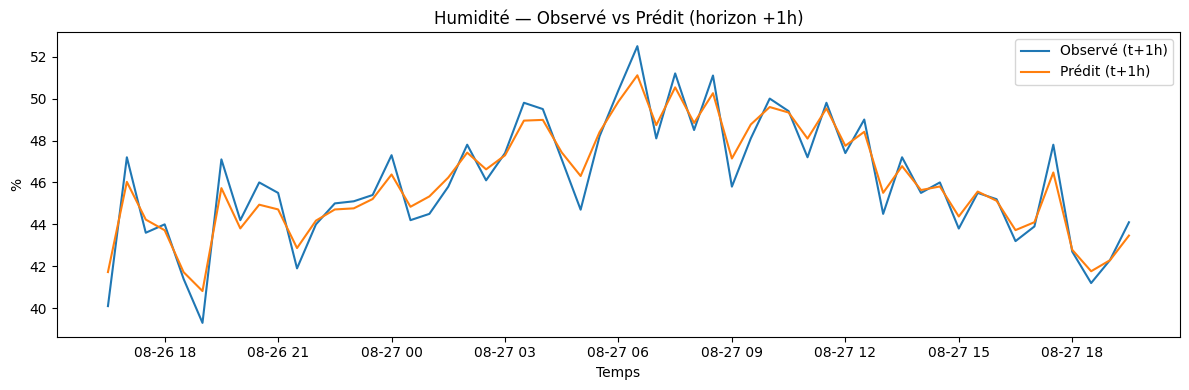

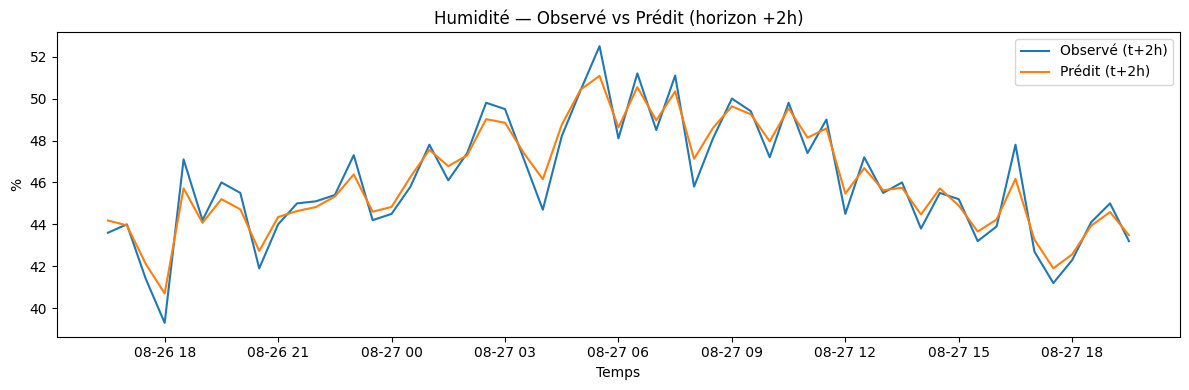

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(
    df_compare["timestamp"], df_compare["humidite_t+2_obs"], label="Observé (t+1h)"
)
plt.plot(
    df_compare["timestamp"], df_compare["humidite_t+2_pred"], label="Prédit (t+1h)"
)
plt.title("Humidité — Observé vs Prédit (horizon +1h)")
plt.xlabel("Temps")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "humidite_obs_vs_pred_t+1h.png"), dpi=120)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(
    df_compare["timestamp"], df_compare["humidite_t+4_obs"], label="Observé (t+2h)"
)
plt.plot(
    df_compare["timestamp"], df_compare["humidite_t+4_pred"], label="Prédit (t+2h)"
)
plt.title("Humidité — Observé vs Prédit (horizon +2h)")
plt.xlabel("Temps")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "humidite_obs_vs_pred_t+2h.png"), dpi=120)
plt.show()


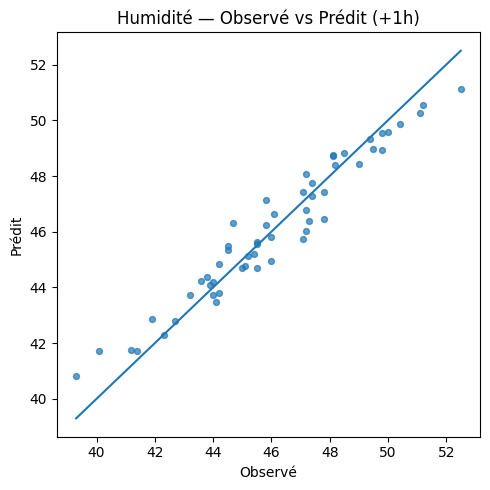

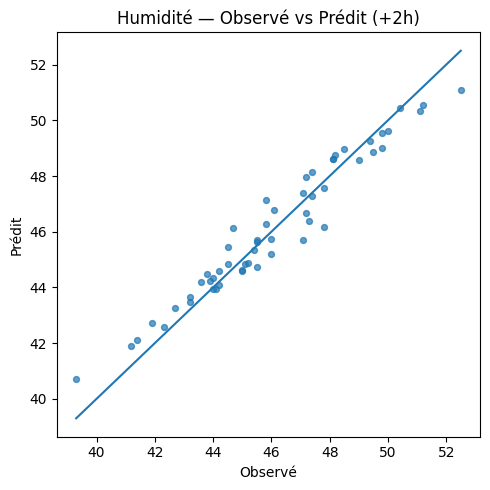

In [14]:
def scatter_obs_pred(y_obs, y_pred, title, outpath):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_obs, y_pred, s=18, alpha=0.7)
    m = min(float(np.min(y_obs)), float(np.min(y_pred)))
    M = max(float(np.max(y_obs)), float(np.max(y_pred)))
    plt.plot([m, M], [m, M])
    plt.xlabel("Observé")
    plt.ylabel("Prédit")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=120)
    plt.show()


scatter_obs_pred(
    df_compare["humidite_t+2_obs"].to_numpy(),
    df_compare["humidite_t+2_pred"].to_numpy(),
    "Humidité — Observé vs Prédit (+1h)",
    os.path.join(FIG_DIR, "humidite_scatter_t+1h.png"),
)

scatter_obs_pred(
    df_compare["humidite_t+4_obs"].to_numpy(),
    df_compare["humidite_t+4_pred"].to_numpy(),
    "Humidité — Observé vs Prédit (+2h)",
    os.path.join(FIG_DIR, "humidite_scatter_t+2h.png"),
)


,humidite_t+2,humidite_t+4,moyenne
humidite_moy_gliss_6,0.086524,0.071075,0.078799
temperature_moy_gliss_2,0.068380,0.084566,0.076473
humidite_moy_gliss_2,0.078136,0.069185,0.073661
temperature_moy_gliss_6,0.071546,0.060738,0.066142
temperature_lag1,0.063743,0.060365,0.062054
temperature_ext_moy_gliss_2,0.050466,0.059670,0.055068
temperature_ext_lag1,0.045633,0.051213,0.048423
temperature,0.032516,0.064282,0.048399
temperature_ext_moy_gliss_6,0.067748,0.028680,0.048214
humidite_lag1,0.054147,0.042010,0.048079


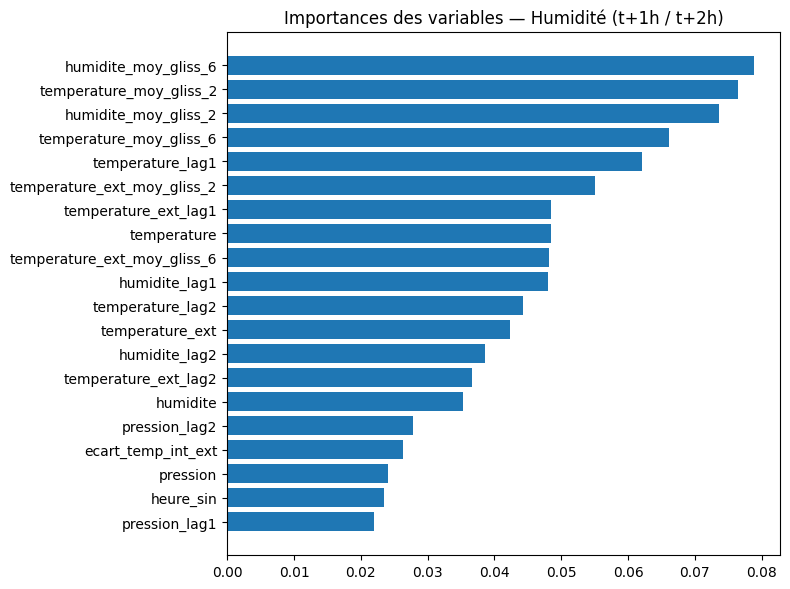

In [15]:
def importances_multioutput(multi_rf, features, target_names):
    per_target = []
    for i, name in enumerate(target_names):
        est = multi_rf.estimators_[i]
        imp = pd.Series(est.feature_importances_, index=features, name=name)
        per_target.append(imp)
    df_imp = pd.concat(per_target, axis=1)
    df_imp["moyenne"] = df_imp.mean(axis=1)
    return df_imp.sort_values("moyenne", ascending=False)


rf_loaded = joblib.load(MODEL_LVL_PATH)
imp = importances_multioutput(rf_loaded, feature_cols, ["humidite_t+2", "humidite_t+4"])
display(imp.head(15))

top = imp.head(20)["moyenne"].iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top.index, top.values)
plt.title("Importances des variables — Humidité (t+1h / t+2h)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "feature_importances_humidite.png"), dpi=120)
plt.show()


In [16]:
df_courant = df_model.copy()
preds_hum = predire_humidite(df_courant)
preds_hum


{'niveaux': {'humidite_t+1h': 43.5, 'humidite_t+2h': 43.5},
 'deltas': {'dH_+1h': 1.9, 'dH_+2h': 1.7}}

## Synthèse 

### 1. Objectifs
- Prévoir l’**humidité intérieure** de la salle aux horizons :
  - **+1h** (t+2 pas de 30 minutes),
  - **+2h** (t+4 pas de 30 minutes).
- Prévoir également la **variation (delta)** de l’humidité aux mêmes horizons afin de capter la tendance (hausse/baisse).

### 2. Données & cibles
- Données en entrée : features enrichies créées dans le Notebook 02 (`capteur_C013_features.csv`).
- Cibles :
  - **Niveaux** : `humidite_t+2`, `humidite_t+4`.
  - **Deltas** : `dH_t+2`, `dH_t+4`.
- Les lignes sans labels en fin de série ont été supprimées.

### 3. Features utilisées
- Signaux instantanés : température, température extérieure, humidité, pression, nombre d’élèves.
- Contexte temporel : ouverture de la salle, sinus/cosinus de l’heure, jour de la semaine, weekend.
- Mémoire (lags) : humidité, température, pression, occupation (t-30 min, t-1h).
- Tendances locales : moyennes glissantes sur 1h et 3h.
- Interactions : ratio d’occupation, écart de température intérieur/extérieur, ouverture × occupation.

### 4. Modèles entraînés
- **Baseline linéaire** : Ridge (multi-sorties).
- **Modèle principal** : RandomForestRegressor multi-sorties avec hyperparamètres tunés :
  - `n_estimators=400`, `max_depth=20`, `min_samples_leaf=1`, `max_features="sqrt"`.
- Validation par **TimeSeriesSplit (5 folds)**.

### 5. Évaluation (MAE / RMSE)
- Les scores (MAE, RMSE arrondis à 1 décimale) montrent que le modèle prédit l’humidité avec une erreur généralement < 2 points de %.
- Les deltas sont plus bruités que les niveaux, mais restent informatifs pour indiquer la tendance.
- Graphiques :
  - Courbes **observé vs prédit** pour +1h et +2h.
  - Scatter avec diagonale y=x pour vérifier la cohérence globale.
